In [62]:
# Remember to update your path
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('C:/Linux_home/Qishi/QishiQR')

from pathlib import Path

from Backtesting.Vectorized.cross_compare import *
from Backtesting.Vectorized.models import *

from Utils.lm import gen_strategy, LM_model
from Utils.MajorContract_split import MajorContracts

import json
import warnings
warnings.filterwarnings(action='ignore')

# ====== Initial Configuration ========

try:
    with open('config.json','r') as f:
        config = json.load(f)
except:
    print("Failed to find the configuration file.")
        
DATA_DIR = config['Tick path']
OUTPUT_DIR = config['Output path']
Strategy_DIR = config['Strategy path']
Major_DIR = config['Major path']
model_order = config['Max model order']
number_of_states = config['State number']
freq = config['Frequency']
offset = config['Offset']
tca = None

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Bu
## Build time series of Major contracts

In [76]:
try:
    ptb = {}
    for contract in ['1606', '1609']:
        ptb[contract] = pd.read_csv(Strategy_DIR+'/Bu_major'+contract +'_' +str(freq) + '_' + str(offset) + '.csv', index_col=0)
    df_bu_train = pd.read_csv(Major_DIR+'/Bu_major_train'+'_' +str(freq) + '_' + str(offset) + '.csv',index_col=0)
    df_bu_test = pd.read_csv(Major_DIR+'/Bu_major_test'+'_' +str(freq) + '_' + str(offset) + '.csv',index_col=0)
except FileNotFoundError:
    bu_mj = MajorContracts(symbol='bu', split_time='2016-7-1', topdir='C:/Linux_home/Qishi/tick2016', 
                           maturity={'1606':['2015-11-1','2016-5-1'], 
                                     '1609':['2016-2-1','2016-8-1'], 
                                     '1612':['2016-6-1','2016-11-15'],
                                     '1706':['2016-10-15','2017-1-31']}, 
                           transitions={'1606':'2016-3-1', '1609':'2016-7-1', '1612':'2016-11-1', '1706':'2017-1-1' },
                           freq=freq, offset=offset)
    df_bu_train, df_bu_test, ptb = bu_mj.create_major_overlap()
    
    # Save files
    for contract in ['1606', '1609']:
        ptb[contract].to_csv(Strategy_DIR+'/Bu_major'+contract +'_' +str(freq) + '_' + str(offset) + '.csv', index=True)
    df_bu_train.to_csv(Major_DIR+'/Bu_major_train'+'_' +str(freq) + '_' + str(offset) + '.csv', index=True)
    df_bu_test.to_csv(Major_DIR+'/Bu_major_test'+'_' +str(freq) + '_' + str(offset) + '.csv', index=True)
    
    

bu1606 C:/Linux_home/Qishi/tick2016/bu
ID trade_range transition_begin transition_end
1606 ['2015-11-1', '2016-5-1'] 2016-01-01 00:00:00 2016-03-01 00:00:00
probability table:  20160104.0 20160229.0
bu1609 C:/Linux_home/Qishi/tick2016/bu
ID trade_range transition_begin transition_end
1609 ['2016-2-1', '2016-8-1'] 2016-03-01 00:00:00 2016-07-01 00:00:00
probability table:  20160229.0 20160630.0
bu1612 C:/Linux_home/Qishi/tick2016/bu
ID trade_range transition_begin transition_end
1612 ['2016-6-1', '2016-11-15'] 2016-07-01 00:00:00 2016-11-01 00:00:00
bu1706 C:/Linux_home/Qishi/tick2016/bu
ID trade_range transition_begin transition_end
1706 ['2016-10-15', '2017-1-31'] 2016-11-01 00:00:00 2016-12-31 00:00:00


In [77]:
strategy = list(ptb.values())
slm = pd.concat(strategy).groupby(['prior']).sum().reset_index()
slm['signal'] = slm.loc[:, '0':'2'].idxmax(axis=1)

## test on bu1612

,Annualized Volatility,Average Daily Return,Average Negative Return,Average Positive Return,Average Return per Trade,Largest Losing Trade,Largest Winning Trade,Max Drawdown,Profit Factor,Sharpe Ratio,Total Number of Trades,Total Return,Winning Rate
0,0.214291,0.009208,-0.002636,0.001797,0.000216,-0.022822,0.023278,-0.058525,0.681762,10.742264,2726,1.589304,0.353265
1,0.247560,0.011901,-0.002772,0.001805,0.000384,-0.022822,0.023278,-0.039505,0.651304,12.018248,1985,1.761661,0.563728
2,0.266014,0.012774,-0.002816,0.001792,0.000459,-0.022822,0.023278,-0.039409,0.636232,12.005423,1783,1.817564,0.657880
3,0.277273,0.010391,-0.002996,0.001827,0.000339,-0.026522,0.023278,-0.073301,0.609838,9.368691,1962,1.665008,0.535678
4,0.258530,0.005555,-0.002647,0.001968,0.000162,-0.026522,0.023278,-0.088785,0.743581,5.371484,2196,1.355505,0.402550
5,0.225141,0.003494,-0.002355,0.002045,0.000095,-0.026522,0.020755,-0.064927,0.868321,3.880096,2359,1.223634,0.328529
6,0.181482,0.004338,-0.002236,0.002039,0.000109,-0.016469,0.013178,-0.053937,0.912174,5.975359,2547,1.277611,0.298783


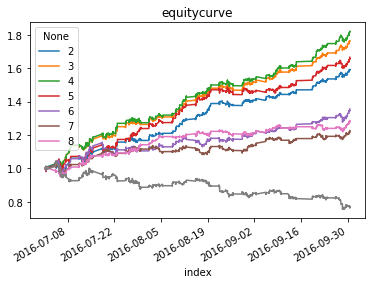

In [65]:
from Backtesting.Vectorized.models import OneContractTest

start = '20160701'
end = '20161001'
max_order=7
tcas = ['None']*max_order

test1 = OneContractTest(DATA_DIR, OUTPUT_DIR,slm)
test1.build('bu', '1612', max_order, freq, offset, start, end, tcas)

test1.run()

test1.plot()
test1.results[0]['benchmark'].plot()
test1.performance

,Annualized Volatility,Average Daily Return,Average Negative Return,Average Positive Return,Average Return per Trade,Largest Losing Trade,Largest Winning Trade,Max Drawdown,Profit Factor,Sharpe Ratio,Total Number of Trades,Total Return,Winning Rate
0,0.327007,0.004603,-0.003902,0.002209,0.000119,-0.056051,0.015168,-0.108101,0.566138,3.519251,1903,1.225561,0.359958
1,0.342243,0.005025,-0.004250,0.002204,0.000175,-0.056051,0.015168,-0.096028,0.518582,3.670940,1406,1.246245,0.552632
2,0.358150,0.005594,-0.004300,0.002216,0.000217,-0.056051,0.015168,-0.096768,0.515324,3.904455,1261,1.274083,0.633624
3,0.401906,0.006882,-0.004608,0.002340,0.000247,-0.056051,0.044677,-0.114257,0.507881,4.281112,1365,1.337238,0.528205
4,0.382338,0.004080,-0.003637,0.002615,0.000131,-0.056051,0.044677,-0.122622,0.718964,2.667725,1523,1.199915,0.397242
5,0.296199,-0.000742,-0.003414,0.002535,-0.000021,-0.068220,0.030071,-0.197314,0.742609,-0.626417,1705,0.963633,0.329619
6,0.282450,-0.001602,-0.002986,0.002635,-0.000042,-0.050413,0.030071,-0.277125,0.882382,-1.417544,1850,0.921525,0.272432


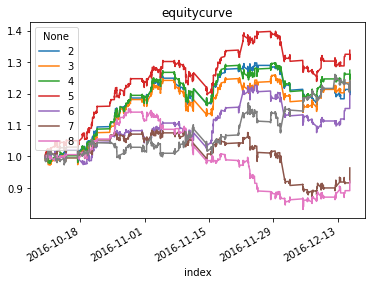

In [66]:
start = '20161001'
end = '20161231'
max_order=7
tcas = ['None']*max_order

test1 = OneContractTest(DATA_DIR, OUTPUT_DIR,slm)
test1.build('bu', '1612', max_order, freq, offset, start, end, tcas)

test1.run()

test1.plot()
test1.results[0]['benchmark'].plot()
test1.performance

## Test on bu major contracts

,Annualized Volatility,Average Daily Return,Average Negative Return,Average Positive Return,Average Return per Trade,Largest Losing Trade,Largest Winning Trade,Max Drawdown,Profit Factor,Sharpe Ratio,Total Number of Trades,Total Return,Winning Rate
0,0.303799,0.003282,-0.003680,0.002200,0.000080,-0.040180,0.026412,-0.096736,0.597665,2.701154,2430,1.193664,0.383951
1,0.299094,0.003155,-0.003986,0.002154,0.000104,-0.037608,0.026412,-0.119880,0.540345,2.636944,1789,1.186132,0.570710
2,0.308003,0.003882,-0.004025,0.002165,0.000139,-0.037608,0.026412,-0.103228,0.537917,3.150814,1643,1.229029,0.632380
3,0.320843,0.003522,-0.004218,0.002222,0.000120,-0.037608,0.026412,-0.128472,0.526818,2.744516,1728,1.207812,0.545139
4,0.354156,0.001580,-0.003497,0.002453,0.000047,-0.047068,0.026412,-0.126464,0.701540,1.115659,1967,1.093248,0.417895
5,0.362576,0.004264,-0.003160,0.002668,0.000115,-0.023376,0.026763,-0.114588,0.844399,2.939895,2183,1.251561,0.363262
6,0.389748,0.003866,-0.002846,0.002708,0.000097,-0.024286,0.046855,-0.103596,0.951651,2.479652,2359,1.228080,0.305638


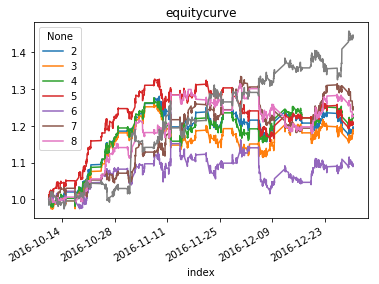

In [79]:
start = '20161001'
end = '20161231'
max_order=7
tcas = ['None']*max_order

test3 = MajorSeriesTest(df_bu_test, OUTPUT_DIR,slm)
test3.build( max_order, offset, start, end, tcas)

test3.run()

test3.plot()
test3.results[0]['benchmark'].plot()
test3.performance

,Annualized Volatility,Average Daily Return,Average Negative Return,Average Positive Return,Average Return per Trade,Largest Losing Trade,Largest Winning Trade,Max Drawdown,Profit Factor,Sharpe Ratio,Total Number of Trades,Total Return,Winning Rate
0,0.262314,0.006478,-0.003198,0.002000,0.000154,-0.040180,0.026412,-0.065766,0.625451,6.173434,5157,1.796735,0.368043
1,0.278342,0.007818,-0.003411,0.001976,0.000255,-0.037608,0.026412,-0.074338,0.579308,7.021549,3775,1.961560,0.567417
2,0.292601,0.008593,-0.003453,0.001972,0.000308,-0.037608,0.026412,-0.062616,0.570934,7.341796,3427,2.056921,0.646046
3,0.302743,0.007133,-0.003631,0.002019,0.000238,-0.037608,0.026412,-0.085396,0.555990,5.890529,3691,1.877391,0.540233
4,0.308530,0.003714,-0.003086,0.002207,0.000110,-0.047068,0.026412,-0.096322,0.715313,3.009253,4163,1.456795,0.410041
5,0.297372,0.003807,-0.002773,0.002366,0.000103,-0.026522,0.026763,-0.098585,0.853319,3.200199,4543,1.468212,0.345366
6,0.298681,0.004130,-0.002556,0.002371,0.000103,-0.024286,0.046855,-0.085415,0.927732,3.456625,4908,1.507955,0.302363


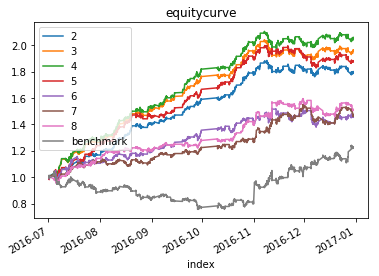

In [94]:
start = '20160601'
end = '20161231'
max_order=7
tcas = ['Fixed']*max_order

test4 = MajorSeriesTest(df_bu_test, OUTPUT_DIR,slm)
test4.build( max_order, offset, start, end, tcas)

test4.run()

test4.plot()
test4.results[0]['benchmark'].plot()
plt.legend()
test4.performance

# HOW TO take care of transitions?
Run test on two individual major contracts

,Annualized Volatility,Average Daily Return,Average Negative Return,Average Positive Return,Average Return per Trade,Largest Losing Trade,Largest Winning Trade,Max Drawdown,Profit Factor,Sharpe Ratio,Total Number of Trades,Total Return,Winning Rate
0,0.258817,0.007134,-0.002103,0.002189,0.000164,-0.008949,0.012465,-0.034667,1.040723,6.890527,697,1.114137,0.291248


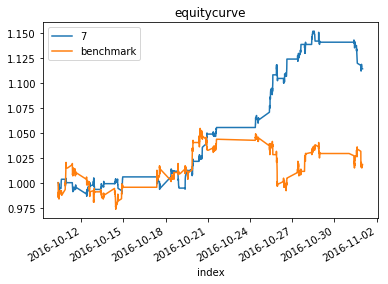

In [115]:
start = '20161001'
end = '20161101'
max_order=7
tcas = ['None']*max_order

test5 = MajorSeriesTest(df_bu_test, OUTPUT_DIR,slm)
test5.build( max_order, offset, start, end, tcas)
test5.run()

test5.plot()
test5.results[0]['benchmark'].plot()
plt.legend()
test5.performance

,Annualized Volatility,Average Daily Return,Average Negative Return,Average Positive Return,Average Return per Trade,Largest Losing Trade,Largest Winning Trade,Max Drawdown,Profit Factor,Sharpe Ratio,Total Number of Trades,Total Return,Winning Rate
0,0.427722,0.002513,-0.003101,0.002919,0.000065,-0.024286,0.046855,-0.114,0.941456,1.468959,1659,1.108069,0.310428


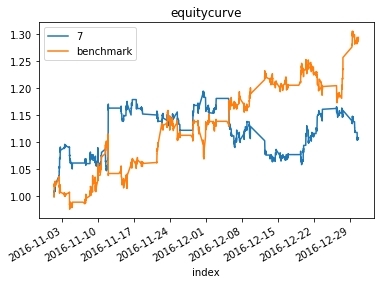

In [114]:
start = '20161101'
end = '20161231'
max_order=7
tcas = ['None']*max_order

test5 = MajorSeriesTest(df_bu_test, OUTPUT_DIR,slm)
test5.build( max_order, offset, start, end, tcas)
test5.run()

test5.plot()
test5.results[0]['benchmark'].plot()
plt.legend()
test5.performance